In [1]:
## Data loading
import pandas as pd
import matplotlib
import numpy as np

# 전체 해류 데이터[m/s]
# NOAA
# OSCAR database - https://www.esr.org/research/oscar/oscar-surface-currents/
# 인공위성 데이터를 토대로 계산하여 만든 데이터, 계산 과정은 위의 링크 확인
entire_data = pd.read_csv('/content/drive/MyDrive/plastic_transporting/data/east_asia_sea_161121_181121.csv')

# 해안선 데이터
latc = pd.read_csv('/content/drive/MyDrive/plastic_transporting/data/eastasian_coastline_latitude.csv', header = None)
lonc = pd.read_csv('/content/drive/MyDrive/plastic_transporting/data/eastasian_coastline_longitude.csv', header = None)

# topo 데이터[m] - 위도 범위: 20~54, 경도 범위: 115~145
topo = pd.read_csv('/content/drive/MyDrive/plastic_transporting/data/eastasian_topo(20_54_115_145).csv', header = None)
latt = pd.read_csv('/content/drive/MyDrive/plastic_transporting/data/eastasian_topo_latitude(20_54).csv', header = None)
lont = pd.read_csv('/content/drive/MyDrive/plastic_transporting/data/eastasian_topo_longitude(115_145).csv', header = None)

# hsl256 칼라바 데이터
hsl256 = pd.read_csv('/content/drive/MyDrive/plastic_transporting/data/hsl256_white.csv')
hsl256_colorbar = matplotlib.colors.ListedColormap(np.array(hsl256), name='hsl256', N=None)

# 강 데이터
yellowsea_river_data = pd.read_csv('/content/drive/MyDrive/plastic_transporting/data/yellowsea_river.csv')

# 월별 river discharge index
river_discharge_data = pd.read_csv('/content/drive/MyDrive/plastic_transporting/data/river_discharge.csv')

# amp 칼라바 데이터
amp_data = pd.read_csv('/content/drive/MyDrive/plastic_transporting/data/amp.csv')
amp = matplotlib.colors.ListedColormap(np.array(amp_data), name='amp', N=None)

In [2]:
#--------------------------------------------------------------------------------------
## 혹시라도 위도, 경도 범위, 내삽의 정도, 시간 간격을 바꾸게 된다면 이 부분 꼭 수정하기
#--------------------------------------------------------------------------------------

#################### 제한 #############################
#위도 범위: 20~54, 경도 범위: 115~145
######################################################

## 위도 범위 - 무조건 정수로 적어
min_lat = 24
max_lat = 45

## 경도 범위 - 무조건 정수로 적어
min_lon = 116
max_lon = 142

# 데이터 내의 위도의 갯수, 경도의 갯수
number_of_latitude = (max_lat - min_lat) * 3 + 1
number_of_longitude = (max_lon - min_lon) * 3 + 1
print(number_of_latitude)
print(number_of_longitude)

# plot extent
plot_extent = [min_lon, max_lon, min_lat, max_lat]

#--------------------------------------------------------------------------------------
# 내삽의 정도 - 현재는 10배 내삽해서 1/30 위도, 경도 간격이다.(약 3, 400m)
# 대략적으로 10배 내삽하였을 때 하루당 3초의 running time
# 100배 내삽하였을 때 하루당 300초의 running time
degree_of_interpolation = 40
d_lon_lat = 1 / 3 / degree_of_interpolation
print(d_lon_lat)
d_lon_lat_before_interpolation = 1 / 3

#--------------------------------------------------------------------------------------
# 플라스틱이 얼마만큼 분산되어 유입되는지
plastic_distribution = 0.02

#--------------------------------------------------------------------------------------
# 다른 강들을 상대비에 따라 곱할 것인데 그 기준
plastic_constant = degree_of_interpolation**2 / 4

64
79
0.008333333333333333


In [3]:
from geopy import distance       # 지구과학, 지리 라이브러리
#--------------------------------------------------------------------------------------
### 위도, 경도 -> Index
#--------------------------------------------------------------------------------------
### 주어진 경도 데이터가 왼쪽에서부터 몇번째 항에 있는지 알려주는 함수
def find_number_lon_dir(lon):
  number = int((lon - min_lon) / d_lon_lat)
  return number

## 주어진 위도 데이터가 위에서부터 몇번째 항에 있는지 알려주는 함수
def find_number_lat_dir(lat):
  number = int((max_lat - lat) / d_lon_lat)
  return number

### 주어진 경도 데이터가 왼쪽에서부터 몇번째 항에 있는지 알려주는 함수 (내삽 전)
def find_number_lon_dir_before_interpolation(lon):
  number = int((lon - min_lon) / d_lon_lat_before_interpolation)
  return number

## 주어진 위도 데이터가 위에서부터 몇번째 항에 있는지 알려주는 함수 (내삽 전)
def find_number_lat_dir_before_interpolation(lat):
  number = int((max_lat - lat) / d_lon_lat_before_interpolation)
  return number


#--------------------------------------------------------------------------------------
### 위도, 경도 <- Index
#--------------------------------------------------------------------------------------
## 위와 반대로 n번째 n항 데이터의 위도, 경도가 어디인지 알려주는 함수
def find_lat_from_number(number):
  lat_grid_after_interpolation_reverse = lat_grid_after_interpolation[::-1]
  lat = lat_grid_after_interpolation_reverse[number]
  return lat

def find_lon_from_number(number):
  lon = lon_grid_after_interpolation[number]
  return lon


#--------------------------------------------------------------------------------------
# 지나가는 함수
## 특정 위도에서 경도 1도 간의 거리(m)가 얼마인지 알려주는 함수
def dist_of_1deg_lon_by_lat(lat, lon):
  loc1 = (lat, lon)
  loc2 = (lat, lon+1)
  dist = distance.great_circle(loc1, loc2).m      # 단위 m
  return dist
#--------------------------------------------------------------------------------------
# 지나가는 함수
## 특정 경도에서 위도 1도 간의 거리(m)가 얼마인지 알려주는 함수
def dist_of_1deg_lat_by_lon(lat, lon):
  loc1 = (lat, lon)
  loc2 = (lat+1, lon)
  dist = distance.great_circle(loc1, loc2).m      # 단위 m
  return dist
#--------------------------------------------------------------------------------------

In [4]:
## 어떤 시간대에 데이터가 있는지 시점만 unique하게 추출
import numpy as np

unique_time = np.unique(entire_data.time).tolist()
#print(unique_time)
print(len(unique_time))

145


In [5]:
## 시점에 따른 데이터 분리(내삽 전) - 딕셔너리 형태

# 날짜 별로 current 데이터를 나누어서 구분할 것이다.
# current_data[날짜][위도 경도][u 또는 v]
# 가령, print(current_data['2017-11-21T00:00:00Z']['25.667 120.0']['u']) = -0.143081338 이다.

# 전체 데이터에서 각 날짜 별 데이터의 갯수(즉, 위도, 경도의 갯수)
number_of_data_per_day = int(len(entire_data) / len(unique_time))      

# current_data(내삽 전) 딕셔너리
current_data = dict()

for d in range(len(unique_time)):
  day = unique_time[d]
  day_dict = dict()
  for data in range(number_of_data_per_day):
    lat = round(entire_data.latitude[data + number_of_data_per_day * d], 3)     # 위도 표시는 소수점 3자리까지만 하였다.
    lon = round(entire_data.longitude[data + number_of_data_per_day * d], 3)    # 경도 표시도 소숫점 3자리까지만 하였다.
    u_vel = entire_data.u[data + number_of_data_per_day * d]
    v_vel = entire_data.v[data + number_of_data_per_day * d]
    key = str(lat) + ' ' +  str(lon)
    day_dict[key] = {'u' : u_vel, 'v' : v_vel}
    
  current_data[day] = day_dict

In [6]:
### 데이터 내삽을 위한 준비단계
import numpy as np

# 내삽하기 전의 그리드
lat_grid_before_interpolation = np.linspace(min_lat, max_lat, number_of_latitude).tolist()
lon_grid_before_interpolation = np.linspace(min_lon, max_lon, number_of_longitude).tolist()
lon_meshgrid_before_interpolation, lat_meshgrid_before_interpolation = np.meshgrid(lon_grid_before_interpolation, lat_grid_before_interpolation)
print('내삽하기 전의 그리드')
print(lat_grid_before_interpolation[::-1])
print(lon_grid_before_interpolation)
print('\n')
#print(lon_meshgrid_before_interpolation)
#print(lat_meshgrid_before_interpolation[::-1])

# 내삽한 이후의 데이터 갯수
number_of_latitude_after_interpolation = (number_of_latitude-1) * (degree_of_interpolation-1) + number_of_latitude
number_of_longitude_after_interpolation = (number_of_longitude-1) * (degree_of_interpolation-1) + number_of_longitude
print('내삽 후 위도 데이터 개수: ' + str(number_of_latitude_after_interpolation))
print('내삽 후 경도 데이터 개수: ' + str(number_of_longitude_after_interpolation))
print('\n')

# 내삽한 이후의 그리드
lat_grid_after_interpolation = np.linspace(min_lat, max_lat, number_of_latitude_after_interpolation).tolist()
lon_grid_after_interpolation = np.linspace(min_lon, max_lon, number_of_longitude_after_interpolation).tolist()
lon_meshgrid_after_interpolation, lat_meshgrid_after_interpolation = np.meshgrid(lon_grid_after_interpolation, lat_grid_after_interpolation)
print('내삽 후의 그리드')
print(lat_grid_after_interpolation[::-1])
print(lon_grid_after_interpolation)
#print(lat_meshgrid_after_interpolation[::-1])
#print(lon_meshgrid_after_interpolation)

내삽하기 전의 그리드
[45.0, 44.666666666666664, 44.33333333333333, 44.0, 43.666666666666664, 43.33333333333333, 43.0, 42.666666666666664, 42.33333333333333, 42.0, 41.666666666666664, 41.33333333333333, 41.0, 40.666666666666664, 40.33333333333333, 40.0, 39.666666666666664, 39.33333333333333, 39.0, 38.666666666666664, 38.33333333333333, 38.0, 37.666666666666664, 37.33333333333333, 37.0, 36.666666666666664, 36.33333333333333, 36.0, 35.666666666666664, 35.33333333333333, 35.0, 34.666666666666664, 34.33333333333333, 34.0, 33.666666666666664, 33.33333333333333, 33.0, 32.666666666666664, 32.33333333333333, 32.0, 31.666666666666664, 31.333333333333332, 31.0, 30.666666666666664, 30.333333333333332, 30.0, 29.666666666666664, 29.333333333333332, 29.0, 28.666666666666664, 28.333333333333332, 28.0, 27.666666666666668, 27.333333333333332, 27.0, 26.666666666666668, 26.333333333333332, 26.0, 25.666666666666668, 25.333333333333332, 25.0, 24.666666666666668, 24.333333333333332, 24.0]
[116.0, 116.33333333333333, 

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]
육지인 지역은 1, 해양인 지역은 0으로 표시하였다.


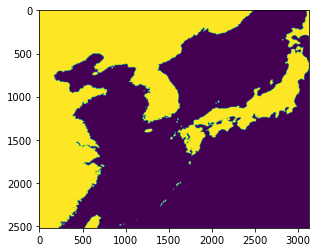

In [7]:
## 지형 내삽 & 어디가 육지고 어디가 바다인지 구분하기
from scipy.interpolate import interpolate
import matplotlib.pyplot as plt

lets_interpolate_topo = interpolate.interp2d(lont, latt, topo, kind = 'linear')
topo_after_interpolation = lets_interpolate_topo(lon_grid_after_interpolation, lat_grid_after_interpolation)[::-1]

#topo_after_interpolation
table_land = np.zeros((number_of_latitude_after_interpolation, number_of_longitude_after_interpolation))
for i in range(number_of_latitude_after_interpolation):
  for j in range(number_of_longitude_after_interpolation):
    if topo_after_interpolation[i][j] > -0.85:
      table_land[i][j] = 1
print((table_land))
print('육지인 지역은 1, 해양인 지역은 0으로 표시하였다.')

plt.imshow(table_land)

In [8]:
### 데이터 내삽
## current data를 내삽 할 것이다.
from scipy.interpolate import interpolate

##### 사용해야하는 함수
# 내삽하기 전의 current data를 위치 별로 table형태로 배열하는 함수
# 여기서 current data는 날짜별 데이터
# 즉, 그 날짜의 current_data[날짜]의 [위도][경도][u 또는 v]를 가져오면된다.
def table_current_before_interpolation(data):
  u_before_interpolation = np.zeros((number_of_latitude, number_of_longitude))
  v_before_interpolation = np.zeros((number_of_latitude, number_of_longitude))
  for lat in range(number_of_latitude):
    lat_value = round(lat_grid_before_interpolation[::-1][lat], 3)
    for lon in range(number_of_longitude):
      lon_value = round(lon_grid_before_interpolation[lon], 3)
      if np.isnan(data[str(lat_value) + ' ' + str(lon_value)]['u']) == True:
        pass
      else:
        u_before_interpolation[lat][lon] = data[str(lat_value) + ' ' + str(lon_value)]['u']
      
      if  np.isnan(data[str(lat_value) + ' ' + str(lon_value)]['v']) == True:
        pass
      else:
        v_before_interpolation[lat][lon] = data[str(lat_value) + ' ' + str(lon_value)]['v']

  return u_before_interpolation, v_before_interpolation


##### 사용해야하는 함수
## table 형태의 current data를 내삽하여 더 자세한 형태의 table 형태로 배열해주는 함수
def table_current_after_interpolation(u, v):  
  # 내삽 함수
  lets_interpolate_u = interpolate.interp2d(lon_grid_before_interpolation, lat_grid_before_interpolation, u, kind = 'linear')
  lets_interpolate_v = interpolate.interp2d(lon_grid_before_interpolation, lat_grid_before_interpolation, v, kind = 'linear')

  # 내삽 진행
  u_after_interpolation = lets_interpolate_u(lon_grid_after_interpolation, lat_grid_after_interpolation)
  v_after_interpolation = lets_interpolate_v(lon_grid_after_interpolation, lat_grid_after_interpolation)
  
  return u_after_interpolation, v_after_interpolation

In [9]:
############### 관련 함수 생성
from datetime import datetime    # 날짜 계산

# 지나가는 함수
## 특정 날짜를 date형태로 바꾸어주는 함수
def date_form(time):
  date = datetime(int(time[:4]), int(time[5:7]), int(time[8:10]), int(time[11:13]), int(time[14:16]), int(time[17:19]))
  return date


##### 사용해야하는 함수
## 데이터 간의 날짜 간격을 알려주는 함수 
# t는 '2017-11-21T00:00:00Z' 형태
def data_dt(t):
  if t == unique_time[-1]:
    dt = 5
  else:
    for time in range(len(unique_time)):
      if unique_time[time] == t:
        dt = (date_form(unique_time[time+1]) - date_form(unique_time[time])).days    # 두 시간간의 일 수 차이
        break
  return dt

# 지나가는 함수
## 특정 위도, 경도 위치에서 오른쪽 방향으로 특정 거리(m)만큼 가면 어떤 위도, 경도를 가지는지 알려주는 함수
def where_plastic_go_by_horiz(lat, lon, x):
  dist1deglon = dist_of_1deg_lon_by_lat(lat, lon)
  new_lon = x / dist1deglon + lon
  return new_lon


# 지나가는 함수
## 특정 위도, 경도 위치에서 위쪽 방향으로 특정 거리(m)만큼 가면 어떤 위도, 경도를 가지는지 알려주는 함수
def where_plastic_go_by_vert(lat, lon, y):
  dist1deglat = dist_of_1deg_lat_by_lon(lat, lon)
  new_lat = y / dist1deglat + lat
  return new_lat


##### 사용해야하는 함수
## 최종적으로 위의 과정을 거쳐 어느 지점에 가는지 알려주는 함수(위도, 경도, x 방향 m거리, y 방향 m거리)
def where_plastic_go(lat_num, lon_num, x, y):
  lat = find_lat_from_number(lat_num)
  lon = find_lon_from_number(lon_num)
  new_lon = where_plastic_go_by_horiz(lat, lon, x)
  new_lat = where_plastic_go_by_vert(lat, lon, y)
  return new_lat, new_lon

##### 사용해야하는 함수
## 현재 위치에서 가장 가까운 포인트(위도, 경도)의 데이터 index 찾는 함수
## 1/9 간격으로 내삽한 상황을 기준으로 만들었다. 
def nearest_location(lat, lon):
  int_lat = float(int(lat))
  int_lon = float(int(lon))

  lat_candidate = np.linspace(int_lat, int_lat +1, 4 + 3 * (degree_of_interpolation - 1))
  lon_candidate = np.linspace(int_lon, int_lon +1, 4 + 3 * (degree_of_interpolation - 1))
  
  diff_lat_candidate = [] 
  diff_lon_candidate = [] 
  for candidate in range(len(lat_candidate)):
    diff_lat_candidate.append(abs(lat_candidate[candidate] - lat))
    diff_lon_candidate.append(abs(lon_candidate[candidate] - lon))

  lat_selected = lat_candidate[np.argmin(diff_lat_candidate)]
  lon_selected = lon_candidate[np.argmin(diff_lon_candidate)]

  return find_number_lat_dir(lat_selected), find_number_lon_dir(lon_selected) 

In [10]:
### 최소 유효 속도 구하기
max_lon_dir_distance = dist_of_1deg_lon_by_lat(min_lat, min_lon)
max_lat_dir_distance = dist_of_1deg_lat_by_lon(min_lat, min_lon)
print('경도 1도 최대 거리: ' + str(max_lon_dir_distance) + ' m')
print('위도 1도 최대 거리: ' + str(max_lat_dir_distance) + ' m')

max_d_lon_dist =  max_lon_dir_distance * d_lon_lat
max_d_lat_dist =  max_lat_dir_distance * d_lon_lat
print('격자 1개 가로 최대거리: ' + str(max_d_lon_dist) + ' m')
print('격자 1개 세로 최대거리: ' + str(max_d_lat_dist) + ' m')
print('\n')
### 단위 격자를 넘을 수 있는 최소한의 속도
print('### 단위 격자를 넘을 수 있는 최소 속도 ###')
min_validation_u = max_d_lon_dist / 3600 / 24
min_validation_v = max_d_lat_dist / 3600 / 24
print('24시간 기준 최소 경도방향 속도(u): ' + str(min_validation_u) + ' m/s')
#print('24시간 기준 최소 위도방향 속도(v): ' + str(min_validation_v) + ' m/s')
min_validation_u = max_d_lon_dist / 3600 / 12
min_validation_v = max_d_lat_dist / 3600 / 12
print('12시간 기준 최소 경도방향 속도(u): ' + str(min_validation_u) + ' m/s')
#print('12시간 기준 최소 위도방향 속도(v): ' + str(min_validation_v) + ' m/s')
min_validation_u = max_d_lon_dist / 3600 / 8
min_validation_v = max_d_lat_dist / 3600 / 8
print('8시간 기준 최소 경도방향 속도(u): ' + str(min_validation_u) + ' m/s')
#print('8시간 기준 최소 위도방향 속도(v): ' + str(min_validation_v) + ' m/s')
min_validation_u = max_d_lon_dist / 3600 / 6
min_validation_v = max_d_lat_dist / 3600 / 6
print('6시간 기준 최소 경도방향 속도(u): ' + str(min_validation_u) + ' m/s')
#print('6시간 기준 최소 위도방향 속도(v): ' + str(min_validation_v) + ' m/s')
min_validation_u = max_d_lon_dist / 3600 / 4
min_validation_v = max_d_lat_dist / 3600 / 4
print('4시간 기준 최소 경도방향 속도(u): ' + str(min_validation_u) + ' m/s')
#print('4시간 기준 최소 위도방향 속도(v): ' + str(min_validation_v) + ' m/s')
min_validation_u = max_d_lon_dist / 3600 / 3
min_validation_v = max_d_lat_dist / 3600 / 3
print('3시간 기준 최소 경도방향 속도(u): ' + str(min_validation_u) + ' m/s')
#print('3시간 기준 최소 위도방향 속도(v): ' + str(min_validation_v) + ' m/s')
min_validation_u = max_d_lon_dist / 3600 / 2
min_validation_v = max_d_lat_dist / 3600 / 2
print('2시간 기준 최소 경도방향 속도(u): ' + str(min_validation_u) + ' m/s')
#print('2시간 기준 최소 위도방향 속도(v): ' + str(min_validation_v) + ' m/s')
min_validation_u = max_d_lon_dist / 3600 / 1
min_validation_v = max_d_lat_dist / 3600 / 1
print('1시간 기준 최소 경도방향 속도(u): ' + str(min_validation_u) + ' m/s')
#print('1시간 기준 최소 위도방향 속도(v): ' + str(min_validation_v) + ' m/s')
min_validation_u = max_d_lon_dist / 3600 / 0.5
min_validation_v = max_d_lat_dist / 3600 / 0.5
print('30분 기준 최소 경도방향 속도(u): ' + str(min_validation_u) + ' m/s')
#print('30분 기준 최소 위도방향 속도(v): ' + str(min_validation_v) + ' m/s')
min_validation_u = max_d_lon_dist / 3600 / 0.2
min_validation_v = max_d_lat_dist / 3600 / 0.2
print('12분 기준 최소 경도방향 속도(u): ' + str(min_validation_u) + ' m/s')
#print('12분 기준 최소 위도방향 속도(v): ' + str(min_validation_v) + ' m/s')
min_validation_u = max_d_lon_dist / 3600 / 0.1
min_validation_v = max_d_lat_dist / 3600 / 0.1
print('6분 기준 최소 경도방향 속도(u): ' + str(min_validation_u) + ' m/s')
#print('6분 기준 최소 위도방향 속도(v): ' + str(min_validation_v) + ' m/s')

경도 1도 최대 거리: 101581.5503455966 m
위도 1도 최대 거리: 111195.08372419146 m
격자 1개 가로 최대거리: 846.5129195466383 m
격자 1개 세로 최대거리: 926.6256977015954 m


### 단위 격자를 넘을 수 있는 최소 속도 ###
24시간 기준 최소 경도방향 속도(u): 0.009797603235493498 m/s
12시간 기준 최소 경도방향 속도(u): 0.019595206470986996 m/s
8시간 기준 최소 경도방향 속도(u): 0.029392809706480495 m/s
6시간 기준 최소 경도방향 속도(u): 0.03919041294197399 m/s
4시간 기준 최소 경도방향 속도(u): 0.05878561941296099 m/s
3시간 기준 최소 경도방향 속도(u): 0.07838082588394799 m/s
2시간 기준 최소 경도방향 속도(u): 0.11757123882592198 m/s
1시간 기준 최소 경도방향 속도(u): 0.23514247765184396 m/s
30분 기준 최소 경도방향 속도(u): 0.4702849553036879 m/s
12분 기준 최소 경도방향 속도(u): 1.1757123882592198 m/s
6분 기준 최소 경도방향 속도(u): 2.3514247765184395 m/s


In [11]:
#### 속도에 따른 update time 변화
def determine_update_time(u, v):
  velocity = np.sqrt(u**2 + v**2)
  if velocity <= 0.019:
    update_time = 24
  elif 0.019 < velocity <= 0.029:
    update_time = 12
  elif 0.029 < velocity <= 0.039:
    update_time = 8
  elif 0.039 < velocity <= 0.058:
    update_time = 6
  elif 0.058 < velocity <= 0.078:
    update_time = 4
  elif 0.078 < velocity <= 0.117:
    update_time = 3
  elif 0.117 < velocity <= 0.235:
    update_time = 2
  elif 0.235 < velocity <= 0.470:
    update_time = 1
  elif 0.470 < velocity <= 1.175:
    update_time = 0.5
  elif 1.175 < velocity <= 2.351:
    update_time = 0.2
  elif 2.351 < velocity:
    update_time = 0.1
    
  return update_time

In [12]:
#### 속도에 따른 update time 변화
def determine_update_time(u, v):
  velocity = np.sqrt(u**2 + v**2)
  if velocity <= 0.02:
    update_time = 24
  elif 0.02 < velocity <= 0.04:
    update_time = 12
  elif 0.04 < velocity <= 0.08:
    update_time = 6
  elif 0.08 < velocity <= 0.16:
    update_time = 3
  elif 0.16 < velocity <= 0.32:
    update_time = 1.5
  elif 0.32 < velocity:
    update_time = 1
    
  return update_time

In [13]:
############################# 핵심 이동함수 #####################################
##### 주어진 데이터 간격동안 이동하여 어느 위도, 경도에 도착했는지 알려주는 함수.
# t는 '2017-11-21T00:00:00Z' 형태

##### Euler Forward Method 사용
def moving(t, initial_lat_num, initial_lon_num, u_after_interpolation, v_after_interpolation):
  
  # 초기 위도, 경도
  latitude_num,longitude_num = initial_lat_num, initial_lon_num
 
  # 다음 데이터가 있는 날짜와의 간격
  # 며칠 간격인지
  dt = data_dt(t)

  # 딕셔너리에서 초기 속도 추출
  # 해당 위치의 속도
  u_plastic = u_after_interpolation[latitude_num][longitude_num]
  v_plastic = v_after_interpolation[latitude_num][longitude_num]


  # 총 움직이는 횟수
  # 데이터 간격동안 플라스틱의 속도를 업데이트 해주는 횟수
  update_time = determine_update_time(u_plastic, v_plastic)
  number_of_moving = int(dt * 24 / update_time)

  #################
  # 해양 플라스틱 쓰레기를 이동을 시켜봅시다.
  for move in range(number_of_moving):    # 이동 횟수
    # \Delta x와 \Delta y
    #vel = np.sqrt(u_plastic**2 + v_plastic**2)
    #if vel < np.sqrt(min_validation_u**2 + min_validation_v**2)/10:
    if table_land[latitude_num][longitude_num] == 1:
      x_distance = 0
      y_distance = 0
    else:
      x_distance = u_plastic * 3600 * update_time  +  np.random.normal(loc = 0, scale =1) * np.sqrt(2 * 10 * update_time * 3600) 
      y_distance = v_plastic * 3600 * update_time  +  np.random.normal(loc = 0, scale =1) * np.sqrt(2 * 10 * update_time * 3600) 

    # 6시간 동안 이동하여 도착한 새로운 위도, 경도 구하기
    latitude_after_move, longitude_after_move = where_plastic_go(latitude_num, longitude_num, x_distance, y_distance)

    # 그 도착한 지점에서 가장 가까운 1/9 위도, 경도 위치
    latitude_num, longitude_num = nearest_location(latitude_after_move, longitude_after_move)
    #latitude = find_lat_from_number(latitude_num)
    #longitude = find_lon_from_number(longitude_num)

    # 새롭게 도착한 지점에서의 새로운 속도
    if 0 < latitude_num < number_of_latitude_after_interpolation and 0 < longitude_num < number_of_longitude_after_interpolation:
      u_plastic = u_after_interpolation[latitude_num][longitude_num]
      v_plastic = v_after_interpolation[latitude_num][longitude_num]
      #if table_land[latitude_num][longitude_num] == 1.:
      #  u_plastic = 0
      #  v_plastic = 0
      #else:
      #  u_plastic = u_after_interpolation[latitude_num][longitude_num]
      #  v_plastic = v_after_interpolation[latitude_num][longitude_num]
    else:
      break

  return latitude_num, longitude_num

In [14]:
def ComparisionWithARGO(initial_time, final_time, initial_lat, initial_lon):
  location_table_time = []
  location_table_lat = []
  location_table_lon = []
  
  # 시간 인덱스화
  index_final_time = unique_time.index(final_time)
  index_initial_time = unique_time.index(initial_time)  
  number_of_time = index_final_time - index_initial_time

  # 위도, 경도 number화
  num_lat, num_lon = nearest_location(initial_lat, initial_lon)
  
  # 저장
  location_table_time.append(initial_time)
  location_table_lat.append(initial_lat)
  location_table_lon.append(initial_lon)
  
  # 이동시키기
  for t in range(number_of_time + 1):

    # 1. 내삽 전 데이터 테이블화
    u_before_interpolation, v_before_interpolation = table_current_before_interpolation(current_data[unique_time[index_initial_time + t]])

    # 2. 내삽
    u_after_interpolation, v_after_interpolation = table_current_after_interpolation(u_before_interpolation, v_before_interpolation)

    # 3. 이동
    num_lat, num_lon = moving(unique_time[index_initial_time + t], num_lat, num_lon, u_after_interpolation, v_after_interpolation)
    
    # 4. 저장
    # 시간
    if unique_time[index_initial_time + t] == unique_time[-1]:
      time = '2018-11-26T00:00:00Z'
    else:
      time = unique_time[index_initial_time + t + 1]
    # 위도, 경도
    lat = find_lat_from_number(num_lat)
    lon = find_lon_from_number(num_lon)
    
    # save
    location_table_time.append(time)
    location_table_lat.append(lat)
    location_table_lon.append(lon)

  return location_table_time, location_table_lat, location_table_lon

In [ ]:
#unique_time = ['2016-11-21T00:00:00Z', '2016-11-26T00:00:00Z', '2016-12-01T00:00:00Z', '2016-12-06T00:00:00Z', '2016-12-11T00:00:00Z', '2016-12-16T00:00:00Z','2016-12-21T00:00:00Z', '2016-12-26T00:00:00Z',
#       '2017-01-01T00:00:00Z', '2017-01-06T00:00:00Z','2017-01-11T00:00:00Z', '2017-01-16T00:00:00Z','2017-01-21T00:00:00Z', '2017-01-26T00:00:00Z','2017-01-31T00:00:00Z', '2017-02-05T00:00:00Z',
#       '2017-02-10T00:00:00Z', '2017-02-15T00:00:00Z','2017-02-20T00:00:00Z', '2017-02-25T00:00:00Z','2017-03-02T00:00:00Z', '2017-03-07T00:00:00Z','2017-03-12T00:00:00Z', '2017-03-18T00:00:00Z',
#       '2017-03-23T00:00:00Z', '2017-03-28T00:00:00Z','2017-04-02T00:00:00Z', '2017-04-07T00:00:00Z','2017-04-12T00:00:00Z', '2017-04-17T00:00:00Z','2017-04-22T00:00:00Z', '2017-04-27T00:00:00Z',
#       '2017-05-02T00:00:00Z', '2017-05-07T00:00:00Z','2017-05-12T00:00:00Z', '2017-05-17T00:00:00Z','2017-05-22T00:00:00Z', '2017-05-28T00:00:00Z','2017-06-02T00:00:00Z', '2017-06-07T00:00:00Z',
#       '2017-06-12T00:00:00Z', '2017-06-17T00:00:00Z','2017-06-22T00:00:00Z', '2017-06-27T00:00:00Z','2017-07-02T00:00:00Z', '2017-07-07T00:00:00Z','2017-07-12T00:00:00Z', '2017-07-17T00:00:00Z',
#       '2017-07-22T00:00:00Z', '2017-07-27T00:00:00Z','2017-08-01T00:00:00Z', '2017-08-06T00:00:00Z','2017-08-12T00:00:00Z', '2017-08-17T00:00:00Z','2017-08-22T00:00:00Z', '2017-08-27T00:00:00Z',
#       '2017-09-01T00:00:00Z', '2017-09-06T00:00:00Z','2017-09-11T00:00:00Z', '2017-09-16T00:00:00Z','2017-09-21T00:00:00Z', '2017-09-26T00:00:00Z','2017-10-01T00:00:00Z', '2017-10-06T00:00:00Z',
#       '2017-10-11T00:00:00Z', '2017-10-16T00:00:00Z','2017-10-22T00:00:00Z', '2017-10-27T00:00:00Z','2017-11-01T00:00:00Z', '2017-11-06T00:00:00Z','2017-11-11T00:00:00Z', '2017-11-16T00:00:00Z',
#       '2017-11-21T00:00:00Z', '2017-11-26T00:00:00Z','2017-12-01T00:00:00Z', '2017-12-06T00:00:00Z','2017-12-11T00:00:00Z', '2017-12-16T00:00:00Z','2017-12-21T00:00:00Z', '2017-12-26T00:00:00Z',
#       '2018-01-01T00:00:00Z', '2018-01-06T00:00:00Z','2018-01-11T00:00:00Z', '2018-01-16T00:00:00Z','2018-01-21T00:00:00Z', '2018-01-26T00:00:00Z','2018-01-31T00:00:00Z', '2018-02-05T00:00:00Z',
#       '2018-02-10T00:00:00Z', '2018-02-15T00:00:00Z','2018-02-20T00:00:00Z', '2018-02-25T00:00:00Z','2018-03-02T00:00:00Z', '2018-03-07T00:00:00Z','2018-03-12T00:00:00Z', '2018-03-18T00:00:00Z',
#       '2018-03-23T00:00:00Z', '2018-03-28T00:00:00Z','2018-04-02T00:00:00Z', '2018-04-07T00:00:00Z','2018-04-12T00:00:00Z', '2018-04-17T00:00:00Z','2018-04-22T00:00:00Z', '2018-04-27T00:00:00Z',
#       '2018-05-02T00:00:00Z', '2018-05-07T00:00:00Z','2018-05-12T00:00:00Z', '2018-05-17T00:00:00Z','2018-05-22T00:00:00Z', '2018-05-28T00:00:00Z','2018-06-02T00:00:00Z', '2018-06-07T00:00:00Z',
#       '2018-06-12T00:00:00Z', '2018-06-17T00:00:00Z','2018-06-22T00:00:00Z', '2018-06-27T00:00:00Z','2018-07-02T00:00:00Z', '2018-07-07T00:00:00Z','2018-07-12T00:00:00Z', '2018-07-17T00:00:00Z',
#       '2018-07-22T00:00:00Z', '2018-07-27T00:00:00Z','2018-08-01T00:00:00Z', '2018-08-06T00:00:00Z','2018-08-12T00:00:00Z', '2018-08-17T00:00:00Z','2018-08-22T00:00:00Z', '2018-08-27T00:00:00Z',
#       '2018-09-01T00:00:00Z', '2018-09-06T00:00:00Z','2018-09-11T00:00:00Z', '2018-09-16T00:00:00Z','2018-09-21T00:00:00Z', '2018-09-26T00:00:00Z','2018-10-01T00:00:00Z', '2018-10-06T00:00:00Z',
#       '2018-10-11T00:00:00Z', '2018-10-16T00:00:00Z','2018-10-22T00:00:00Z', '2018-10-27T00:00:00Z','2018-11-01T00:00:00Z', '2018-11-06T00:00:00Z','2018-11-11T00:00:00Z', '2018-11-16T00:00:00Z',
#       '2018-11-21T00:00:00Z']

In [15]:
# 예시로 WMO ID : 2901783 실행
initial_date = '2016-11-21T00:00:00Z'
final_date = '2017-03-02T00:00:00Z'


file_name = '/content/drive/MyDrive/plastic_transporting/plastic_table_wo_beaching/all' + final_date + '.csv'
table = np.array(pd.read_csv(file_name))
fig = plt.figure(figsize=(30,20)) 
plt.imshow(3.425* (table), cmap = amp, extent = plot_extent, alpha = 1 )
plt.clim(0,200)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Plastics(kg)',  fontsize = 25)
plt.imshow(table_land , 'gist_earth_r', extent = plot_extent, alpha = 0.2)

location_table_time_y, location_table_lat_y, location_table_lon_y = ComparisionWithARGO(initial_date, final_date, 31, 124)  # 양쯔
location_table_time_t, location_table_lat_t, location_table_lon_t = ComparisionWithARGO(initial_date, final_date, 27.5, 123)  # 대만
location_table_time_s, location_table_lat_s, location_table_lon_s = ComparisionWithARGO(initial_date, final_date, 37.5, 125)  # 서울
#location_table_time_tk, location_table_lat_tk, location_table_lon_tk = ComparisionWithARGO(initial_date, final_date, 33.5, 138)  # 도쿄
location_table_time_b, location_table_lat_b, location_table_lon_b = ComparisionWithARGO(initial_date, final_date, 38, 120)  # 북경
location_table_time_h, location_table_lat_h, location_table_lon_h = ComparisionWithARGO(initial_date, final_date, 41, 131)  # 함경


plt.plot(location_table_lon_y, location_table_lat_y, 'yo-', linewidth = 5); plt.plot(location_table_lon_y[-1], location_table_lat_y[-1], 'yo-', markersize = 15)
plt.plot(location_table_lon_t, location_table_lat_t, 'yo-', linewidth = 5); plt.plot(location_table_lon_t[-1], location_table_lat_t[-1], 'yo-', markersize = 15)
plt.plot(location_table_lon_s, location_table_lat_s, 'yo-', linewidth = 5); plt.plot(location_table_lon_s[-1], location_table_lat_s[-1], 'yo-', markersize = 15)
#plt.plot(location_table_lon_tk, location_table_lat_tk, 'yo-', linewidth = 5); plt.plot(location_table_lon_tk[-1], location_table_lat_tk[-1], 'yo-', markersize = 15)
plt.plot(location_table_lon_b, location_table_lat_b, 'yo-', linewidth = 5); plt.plot(location_table_lon_b[-1], location_table_lat_b[-1], 'yo-', markersize = 15)
plt.plot(location_table_lon_h, location_table_lat_h, 'yo-', linewidth = 5); plt.plot(location_table_lon_h[-1], location_table_lat_h[-1], 'yo-', markersize = 15)
plt.ylim(min_lat, max_lat)
plt.xlim(min_lon, max_lon)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

FileNotFoundError: ignored

In [ ]:
plt.quiver(location_table_lon_y[:-1], location_table_lat_y[:-1], location_table_lon_y[1:] - location_table_lon_y[:-1], location_table_lat_y[1:]-location_table_lat_y[:-1], linewidth = 5)




TypeError: ignored

In [ ]:
print(unique_time)

['2016-11-21T00:00:00Z', '2016-11-26T00:00:00Z', '2016-12-01T00:00:00Z', '2016-12-06T00:00:00Z', '2016-12-11T00:00:00Z', '2016-12-16T00:00:00Z', '2016-12-21T00:00:00Z', '2016-12-26T00:00:00Z', '2017-01-01T00:00:00Z', '2017-01-06T00:00:00Z', '2017-01-11T00:00:00Z', '2017-01-16T00:00:00Z', '2017-01-21T00:00:00Z', '2017-01-26T00:00:00Z', '2017-01-31T00:00:00Z', '2017-02-05T00:00:00Z', '2017-02-10T00:00:00Z', '2017-02-15T00:00:00Z', '2017-02-20T00:00:00Z', '2017-02-25T00:00:00Z', '2017-03-02T00:00:00Z', '2017-03-07T00:00:00Z', '2017-03-12T00:00:00Z', '2017-03-18T00:00:00Z', '2017-03-23T00:00:00Z', '2017-03-28T00:00:00Z', '2017-04-02T00:00:00Z', '2017-04-07T00:00:00Z', '2017-04-12T00:00:00Z', '2017-04-17T00:00:00Z', '2017-04-22T00:00:00Z', '2017-04-27T00:00:00Z', '2017-05-02T00:00:00Z', '2017-05-07T00:00:00Z', '2017-05-12T00:00:00Z', '2017-05-17T00:00:00Z', '2017-05-22T00:00:00Z', '2017-05-28T00:00:00Z', '2017-06-02T00:00:00Z', '2017-06-07T00:00:00Z', '2017-06-12T00:00:00Z', '2017-06-17T00:

In [ ]:
x = np.zeros((len(table1[0]), len(table1[0][0])))
y = np.zeros((len(table1[0]), len(table1[0][0])))
for i in range(len(table1[0])):
  for j in range(len(table1[0][0])):
    if table1[0][i][j] ** 2 + table1[1][i][j] ** 2 >0:
      x[i][j] = table1[0][i][j] * 3600 * 24 + np.random.normal(loc = 0, scale =1) * np.sqrt(2 * 10 * 24 * 3600)
      y[i][j] = table1[1][i][j] * 3600 * 24 + np.random.normal(loc = 0, scale =1) * np.sqrt(2 * 10 * 24 * 3600)

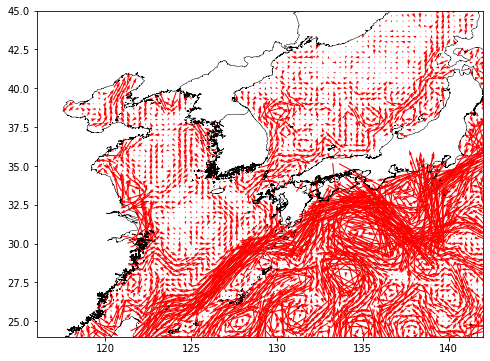

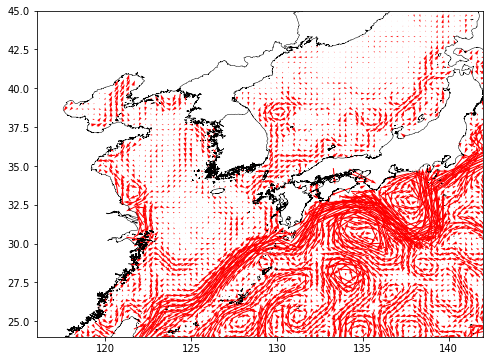

In [ ]:
# x축 방향 속도 내삽 전 데이터 plot
fig1 = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_facecolor('w')
plt.plot(lonc, latc, color = 'k', linewidth = 0.5)
plt.quiver(lon_meshgrid_before_interpolation, lat_meshgrid_before_interpolation[::-1], x, y, color = 'r', minlength = 0, scale = 500000, pivot = 'mid')
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.show()

# x축 방향 속도 내삽 전 데이터 plot
fig1 = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_facecolor('w')
plt.plot(lonc, latc, color = 'k', linewidth = 0.5)
plt.quiver(lon_meshgrid_before_interpolation, lat_meshgrid_before_interpolation[::-1], table1[0], table1[1], color = 'r', minlength = 0,scale = 10,  pivot = 'mid')
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.show()


In [ ]:
(table1)

(array([[ 0.        ,  0.        ,  0.        , ..., -0.02986708,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.04288559,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.01265929,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.14067217,
          0.2888778 ,  0.45752398],
        [ 0.        ,  0.        ,  0.        , ...,  0.17503532,
          0.35067739,  0.53108624],
        [ 0.        ,  0.        ,  0.        , ..., -0.03842061,
          0.04984487,  0.17168723]]),
 array([[ 0.        ,  0.        ,  0.        , ..., -0.07222442,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.02800245,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.02234999,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [ ]:
from math import nan
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

file1 = nc.Dataset('/content/drive/MyDrive/plastic_transporting/data/oscar_currents_final_20180325.nc')
#print(file1)
u = file1['u']
#fig1 = plt.figure(figsize=(24,12))
#plt.imshow(u[0,:,:])

# 원하는 경도 * 4, 360+ 원하는 위도 * 4
## 위도 범위 - 무조건 정수로 적어
min_lat = 24
max_lat = 45

## 경도 범위 - 무조건 정수로 적어
min_lon = 116
max_lon = 142

#위도 범위: 20~54, 경도 범위: 115~145
num_of_latitude25 = (max_lat - min_lat) * 4 + 1
num_of_longitude25 = (max_lon - min_lon) * 4 + 1
x25 = np.zeros((num_of_latitude25, num_of_longitude25))
y25 = np.zeros((num_of_latitude25, num_of_longitude25))

for i in range(num_of_latitude25):
  for j in range(num_of_longitude25):
    u = file1['u'][0, (min_lon + j * 0.25) *4 ,(max_lat - i * 0.25) * 4 + 360]
    v = file1['v'][0, (min_lon + j * 0.25) *4 ,(max_lat - i * 0.25) * 4 + 360]
    x25[i][j] = u * 3600 * 24 + np.random.normal(loc = 0, scale =1) * np.sqrt(2 * 10 * 24 * 3600)
    y25[i][j] = v * 3600 * 24 + np.random.normal(loc = 0, scale =1) * np.sqrt(2 * 10 * 24 * 3600)    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Warning: converting a masked element to nan.


In [ ]:
lat_grid_before_interpolation = np.linspace(min_lat, max_lat, num_of_latitude25).tolist()
lon_grid_before_interpolation = np.linspace(min_lon, max_lon, num_of_longitude25).tolist()
lon_meshgrid_before_interpolation, lat_meshgrid_before_interpolation = np.meshgrid(lon_grid_before_interpolation, lat_grid_before_interpolation)


In [ ]:
# 쿠로시오 해류 부분 삭제하기

for i in range(31):
  for j in range(49):
    if j + 56 > int(- 1.6 * (i + 20) + 148):
      x25[i + 20][j + 56] = 0
      y25[i + 20][j + 56] = 0

for i in range(35):
  for j in range(89):
    if j + 16 > int(-20 / 17 * (i + 50) + 20 * 84 / 17 +16):
      x25[i + 50][j + 16] = 0
      y25[i + 50][j + 16] = 0

In [ ]:
len(x25[0])

105

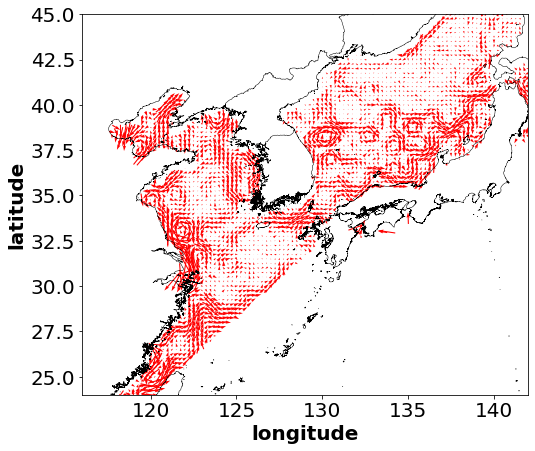

In [ ]:
# x축 방향 속도 내삽 전 데이터 plot
fig1 = plt.figure(figsize=(8,7))
ax = plt.gca()
ax.set_facecolor('w')
plt.plot(lonc, latc, color = 'k', linewidth = 0.5)
plt.quiver(lon_meshgrid_before_interpolation, lat_meshgrid_before_interpolation[::-1], x25, y25, color = 'r', minlength = 0, scale = 800000, pivot = 'mid')
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.xlabel('longitude', fontsize = 20, fontweight = 'bold')
plt.ylabel('latitude', fontsize = 20, fontweight = 'bold')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()